#  Прогнозирование заказов такси

**Описание**

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

**Задача:** 

Спрогнозировать количество заказов такси на следующий час, построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**План проведения исследования:**

1. Загрузка данных и их ресемплирование по одному часу.
2. Анализ данных.
3. Обучение моделей с различными гиперпараметрами (тестовая выборка размером 10% от исходных данных).
4. Проверка данных на тестовой выборке.



<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

## Подготовка

**Импорт библиотек**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

!pip install fast_ml
from sklearn.model_selection import train_test_split
from fast_ml.model_development import train_valid_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from lightgbm import LGBMRegressor

**Импорт данных**

In [2]:
data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
display (data)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»). изучим данные.

Timestamp('2018-03-01 00:00:00')

Timestamp('2018-08-31 23:50:00')

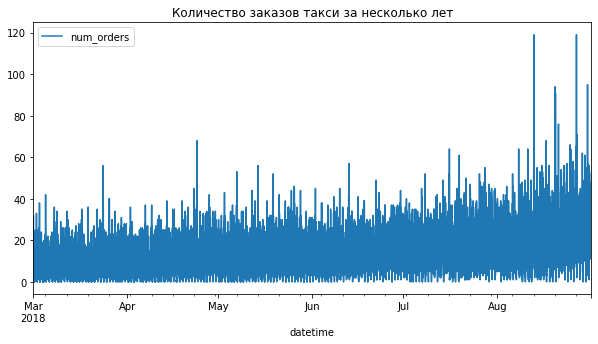

In [6]:
data.sort_index(inplace=True)
display (data.index.min(), data.index.max())

data.plot(figsize=(10, 5))
plt.title('Количество заказов такси за несколько лет')
plt.show()

У нас есть данные за 6 месяцев с марта по август с разницей во времени - 10 минут.

**Ресемплирование данных**

In [7]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

**Скользящее среднее**

Проанализируем изменения количества заказов в течении 6 месяцев, недели и 2 дней.

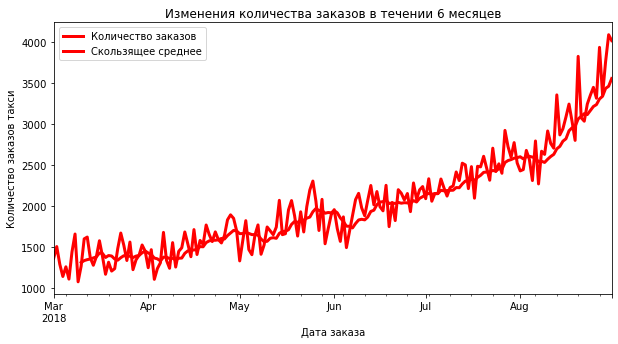

In [8]:
data_2 = data.resample('1D').sum()
data_2['rolling_mean'] = data_2.rolling(10).mean()
data_2.plot(figsize=(10, 5), linewidth = 3, color = 'red')

plt.title('Изменения количества заказов в течении 6 месяцев')
plt.xlabel('Дата заказа')
plt.ylabel('Количество заказов такси')
plt.legend(['Количество заказов', 'Скользящее среднее'])
plt.show()

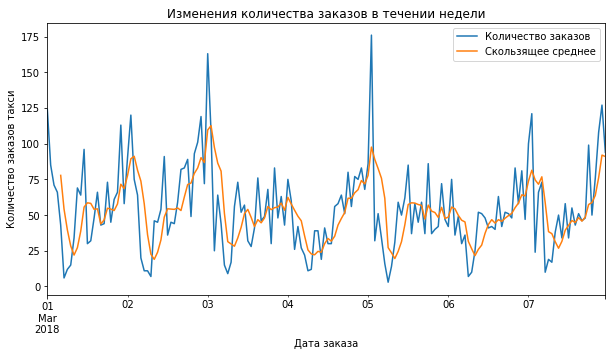

In [9]:
data_2 = data['2018-03-01':'2018-03-7'].resample('1H').sum()
data_2['rolling_mean'] = data_2.rolling(5).mean()
data_2.plot(figsize=(10, 5))

plt.title('Изменения количества заказов в течении недели')
plt.xlabel('Дата заказа')
plt.ylabel('Количество заказов такси')
plt.legend(['Количество заказов', 'Скользящее среднее'])
plt.show()

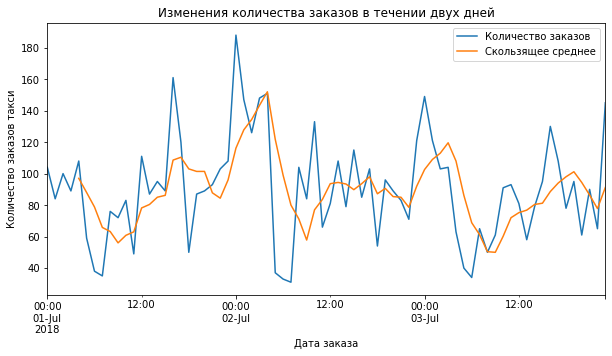

In [10]:
data_2 = data['2018-07-01':'2018-07-3'].resample('1H').sum()
data_2['rolling_mean'] = data_2.rolling(5).mean()
data_2.plot(figsize=(10, 5))

plt.title('Изменения количества заказов в течении двух дней')
plt.xlabel('Дата заказа')
plt.ylabel('Количество заказов такси')
plt.legend(['Количество заказов', 'Скользящее среднее'])
plt.show()

**Тренды и сезонность**

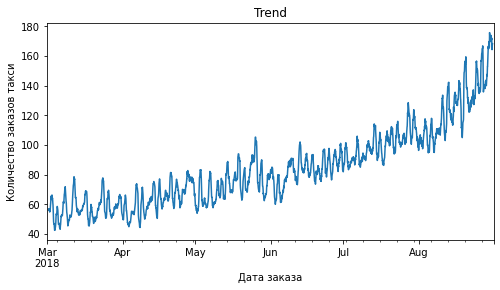

In [11]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(8, 4))
decomposed.trend.plot(ax=plt.gca())


plt.title('Trend')
plt.xlabel('Дата заказа')
plt.ylabel('Количество заказов такси')
plt.show()

Как мы можем видеть, на графике прослеживается следующий тренд - количество заказов такси постепенно растет к августу.

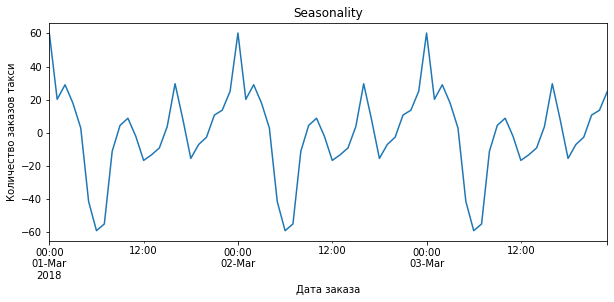

In [12]:

plt.figure(figsize=(10, 4))
ax = decomposed.seasonal['2018-03-01' : '2018-03-03'].plot(ax=plt.gca())

plt.title('Seasonality')
plt.xlabel('Дата заказа')
plt.ylabel('Количество заказов такси')

plt.show()

На графике мы можем видеть суточную сезонность: пик нагрузки приходится на 12 часов ночи, что логично - ночью общественный транспорт не ходит, приходится заказывать такси. Спад количества заказов - 6 утра, что тоже можно объяснить: общественный транспорт уже работает и до начала рабочего дня - 2-3 часа, можно доехать без пробок и успеть на работу.

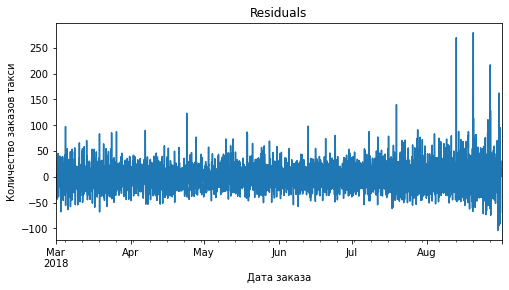

In [13]:
plt.figure(figsize=(8, 4))
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.xlabel('Дата заказа')
plt.ylabel('Количество заказов такси')
plt.show()

## Обучение

**Создание признаков**

In [14]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].rolling(rolling_mean_size).mean()
    data['rolling_mean'] = data['rolling_mean'].shift()
    
    return data


In [15]:
data = make_features(data, 24, 5)

In [16]:
# удалим пропуски
data = data.dropna()

In [17]:
# подберем лучшие параметры для признаков

train, test = train_test_split(data, shuffle=False, test_size=0.1)

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [18]:
model = LinearRegression()

model.fit(features_train, target_train)
prediction = model.predict(features_test)

print("MAE тестовой выборки:", mean_squared_error(target_test, prediction) ** 0.5)

MAE тестовой выборки: 45.21464012141321


In [19]:
data.shape

(4392, 29)

**Разделение на выборки**

In [20]:
# отделим тестовую выборку - 10%, валидационную - 20% и обучающую - 70%
features_train, target_train, features_valid, target_valid, features_test, target_test = train_valid_test_split(
    data, target = 'num_orders', train_size=0.7, valid_size=0.2, test_size=0.1, 
    method='sorted', sort_by_col='datetime')

In [21]:
features_test.shape

(440, 28)

**Обучение моделей**

Линейная регрессия

In [22]:
# features_train, features_valid, target_train, target_valid
linear_model = LinearRegression()

linear_model.fit(features_train, target_train)
prediction = linear_model.predict(features_valid)

print("RMSE валидационной выборки:", mean_squared_error(target_valid, prediction) ** 0.5)



RMSE валидационной выборки: 32.83230987765022


Случайный лес

In [23]:
%%time

best_forest_model = ''
best_forest_result = 1000
for depth in range(1, 20, 2):
    for est in range(10, 40, 10):
        forest_model = RandomForestRegressor(random_state=12345, max_depth=depth, n_estimators=est)
        forest_model.fit(features_train, target_train)
        prediction = forest_model.predict(features_valid)
        
        rmse = mean_squared_error(target_valid, prediction) ** 0.5
        
        if rmse < best_forest_result:
            best_forest_result = rmse
            best_forest_model = forest_model
            
print ('Лучший результат случайного леса: ', round(best_forest_result))
print ('Лучшая модель случайного леса: ', best_forest_model)


Лучший результат случайного леса:  33
Лучшая модель случайного леса:  RandomForestRegressor(max_depth=13, n_estimators=30, random_state=12345)
Wall time: 18.4 s


Градиентный бустинг

In [24]:
%%time

trees = [10, 100, 1000]
best_gbm_model = ''
best_gbm_result = 1000

for tree in trees:
    gbm_model= LGBMRegressor(n_estimators=tree, max_depth=8, num_leaves=200)
    gbm_model.fit(features_train, target_train)
        
    prediction = gbm_model.predict(features_valid)
    rmse = mean_squared_error(target_valid, prediction) ** 0.5
        
    if rmse < best_gbm_result:
        best_gbm_result = rmse
        best_gbm_model = gbm_model

print('Лучший RMSE градиентного бустинга: ', round(best_gbm_result))
print ('Лучшая модель градиентного бустинга: ', best_gbm_model)

Лучший RMSE градиентного бустинга:  32
Лучшая модель градиентного бустинга:  LGBMRegressor(max_depth=8, num_leaves=200)
Wall time: 2.99 s


## Тестирование

In [25]:
linear_prediction = linear_model.predict(features_test)

print("RMSE тестовой выборки:", mean_squared_error(target_test, linear_prediction) ** 0.5)

RMSE тестовой выборки: 46.623859812792084


In [26]:
forest_prediction = best_forest_model.predict(features_test)
print('RMSE тестовой выборки: ', mean_squared_error(target_test, forest_prediction) ** 0.5)

RMSE тестовой выборки:  56.01165494588525


In [27]:
gbm_prediction = best_gbm_model.predictprediction = model.predict(features_test)

print("RMSE тестовой выборки:", mean_squared_error(target_test, gbm_prediction) ** 0.5)

RMSE тестовой выборки: 45.21464012141321


**Визуализация**

In [28]:
pred = pd.Series(linear_prediction, index=target_test.index)


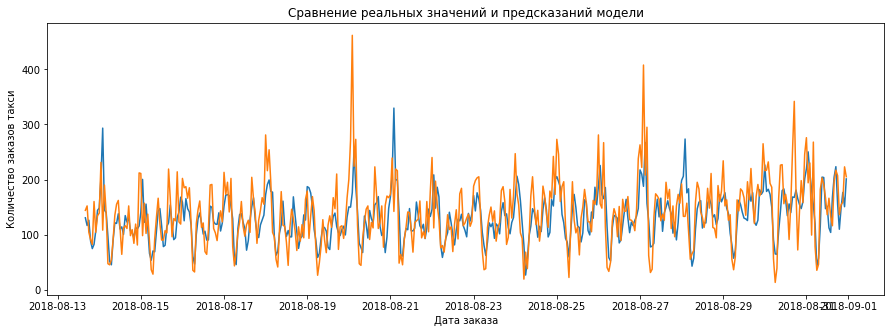

In [29]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(pred)
ax.plot(target_test)

plt.title('Сравнение реальных значений и предсказаний модели')
plt.xlabel('Дата заказа')
plt.ylabel('Количество заказов такси')
plt.show()

На графике мы можем видеть, что предсказания моделируют реальное количество заказов такси, лишь некоторые аномальные значения модель не предсказывает в точности.

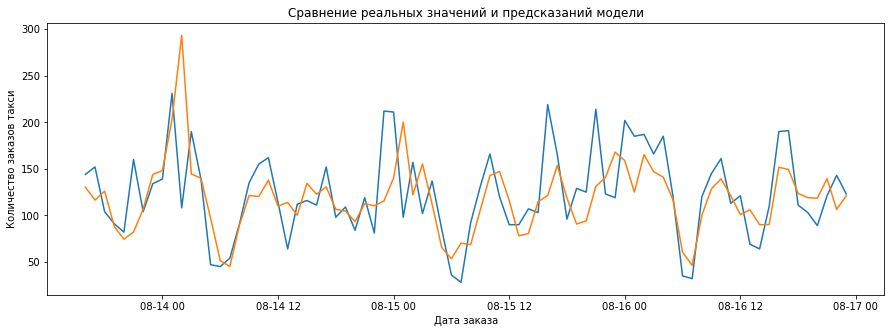

In [30]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(target_test['2018-08-13' : '2018-08-16'])
ax.plot(pred['2018-08-13' : '2018-08-16'])

plt.title('Сравнение реальных значений и предсказаний модели')
plt.xlabel('Дата заказа')
plt.ylabel('Количество заказов такси')
plt.show()

Модель учитывает суточные колебания значений и предсказывает, как будет меняться количество заказов в течении дня.

**Вывод**

Задача проека - спрогнозировать количество заказов такси на следующий час, построить модель для такого предсказания со значением метрики RMSE не больше 48 - выполнена.

Модель линейной регрессии - наиболее точная, лучший результат - 46.

В исследовании были выполнены следующие шаги:

- иморт, ресемплирование данных
- анализ скользящего среднего, сезонности и трендов
- созданы признаки и разделены на выборки
- обучено несколько моделей